This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is based off of `notebooks/hf-transfer/probe-scaling.ipynb`. It has the added capability of modeling the embedding distribution with a Gaussian mixture model.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import dataclasses
import pathlib
import sys

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.gmm import GMMDataset
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10, imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip

### Load data

In [3]:
dataset_cfg = cifar10.CIFAR10()
# embedder_cfg = openai_clip.OpenaiClipConfig(id="openai/ViT-L/14@336px")
embedder_cfg = laion_clip.LaionClipConfig(
    id="hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
)
# embedder_cfg = msft_beit.MsftBeitConfig(
#     id="hf/microsoft/beit-large-patch16-224-pt22k"
# )

embedding_cfg = gen_embeddings.Config(
    dataset_cfg=dataset_cfg,
    embedder_cfg=embedder_cfg,
)
probe_cfg = probe_embeddings.Config(
    embedder_cfg=embedder_cfg,
    dataset_cfg=dataset_cfg,
)

DS = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
    np.float32
)
DS.xs_train.shape, DS.xs_test.shape, DS.xs_test.dtype

((50000, 1280), (10000, 1280), dtype('float32'))

### Dataset info

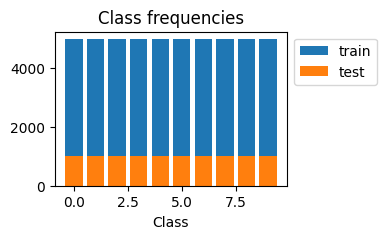

In [4]:
fig = probe_embeddings.plot_class_frequencies(DS)
fig.set_size_inches(w=3, h=2)

### Fit gaussian proxy model to data

In [10]:
ds_gmm = GMMDataset.construct_proxy_gpu(
    DS,
    with_label_noise=False,
    cov_eps=1e-6,
)

In [15]:
ds_gmm_noised = GMMDataset.construct_proxy_gpu(
    DS,
    with_label_noise=True,
    cov_eps=1e-6,
)

In [6]:
def estimate_optimal_errs(
    ds_gmm: EmbeddingDataset,
    n_samples_per_class: int = 1_000,
) -> np.ndarray:
    n_classes = len(ds_gmm.metadata["uys"])
    mus = ds_gmm.metadata["mus"]
    covs = ds_gmm.metadata["covs"]
    label_flip_probs = ds_gmm.metadata["label_flip_probs"]

    errs = np.zeros(n_classes)
    for i in range(n_classes):
        xs = np.random.multivariate_normal(
            mean=mus[i], cov=covs[i], size=n_samples_per_class
        )
        ys = np.random.choice(
            n_classes,
            size=n_samples_per_class,
            p=label_flip_probs[i],
        )

        # scores[i, j] is the probability xs[i] is of class j
        scores = np.zeros((n_samples_per_class, n_classes))
        for j in range(n_classes):
            scores[:, j] = scipy.stats.multivariate_normal.logpdf(
                xs, mean=mus[j], cov=covs[j], allow_singular=True
            )

        # preds[i] is the predicted class for xs[i]
        preds = scores.argmax(axis=1)

        errs[i] = (preds != ys).mean()

    return errs

In [ ]:
min_allowed_sval = 1e-6

n_classes = len(ds_gmm.metadata["uys"])
mus = ds_gmm.metadata["mus"]
covs = ds_gmm.metadata["covs"]
label_flip_probs = ds_gmm.metadata["label_flip_probs"]

svals = np.linalg.svd(covs, compute_uv=False, hermitian=True)
svals = np.linalg.svd

errs = np.zeros(n_classes)
for i in range(n_classes):
    xs = np.random.multivariate_normal(
        mean=mus[i], cov=covs[i], size=n_samples_per_class
    )
    ys = np.random.choice(
        n_classes,
        size=n_samples_per_class,
        p=label_flip_probs[i],
    )

    # scores[i, j] is the probability xs[i] is of class j
    scores = np.zeros((n_samples_per_class, n_classes))
    for j in range(n_classes):
        scores[:, j] = scipy.stats.multivariate_normal.logpdf(
            xs, mean=mus[j], cov=covs[j], allow_singular=True
        )

    # preds[i] is the predicted class for xs[i]
    preds = scores.argmax(axis=1)

    errs[i] = (preds != ys).mean()

In [7]:
ds_gmm.metadata["errs"] = estimate_optimal_errs(ds_gmm)
print(ds_gmm.metadata["errs"])
print(ds_gmm.metadata["errs"].mean())

ds_gmm_noised.metadata["errs"] = estimate_optimal_errs(ds_gmm_noised)
print(ds_gmm_noised.metadata["errs"])
print(ds_gmm_noised.metadata["errs"].mean())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
[0.297 0.317 0.334 0.312 0.239 0.201 0.171 0.117 0.128 0.162]
0.2278


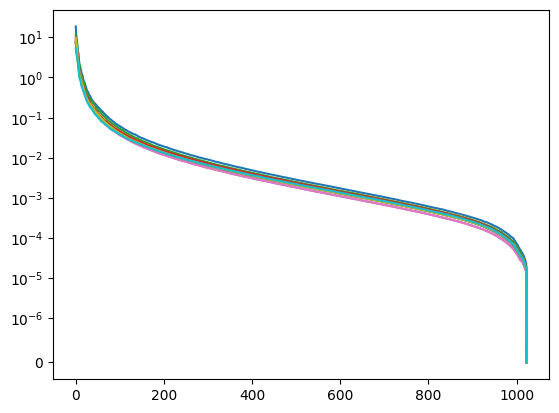

In [16]:
covs = ds_gmm.metadata["covs"]
# Get singular values of covs
svals = np.linalg.svd(covs, compute_uv=False, hermitian=True)

for i in range(10):
    plt.plot(svals[i], label=f"Class {i}")

plt.yscale("symlog", linthresh=1e-6)

### Visualize embeddings with UMAP

In [8]:
fig = probe_embeddings.plot_umap(DS, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

fig = probe_embeddings.plot_umap(ds_gmm, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

fig = probe_embeddings.plot_umap(ds_gmm_noised, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

### Get scaling data

In [9]:
%%capture
df = probe_embeddings.get_scaling_results(
    ds=DS,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
    with_per_class=False,
)

In [10]:
%%capture
df_gmm = probe_embeddings.get_scaling_results(
    ds=ds_gmm,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
    with_per_class=False,
)

In [11]:
%%capture
df_gmm_noised = probe_embeddings.get_scaling_results(
    ds=ds_gmm_noised,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
    with_per_class=False,
)

### Plot scaling data

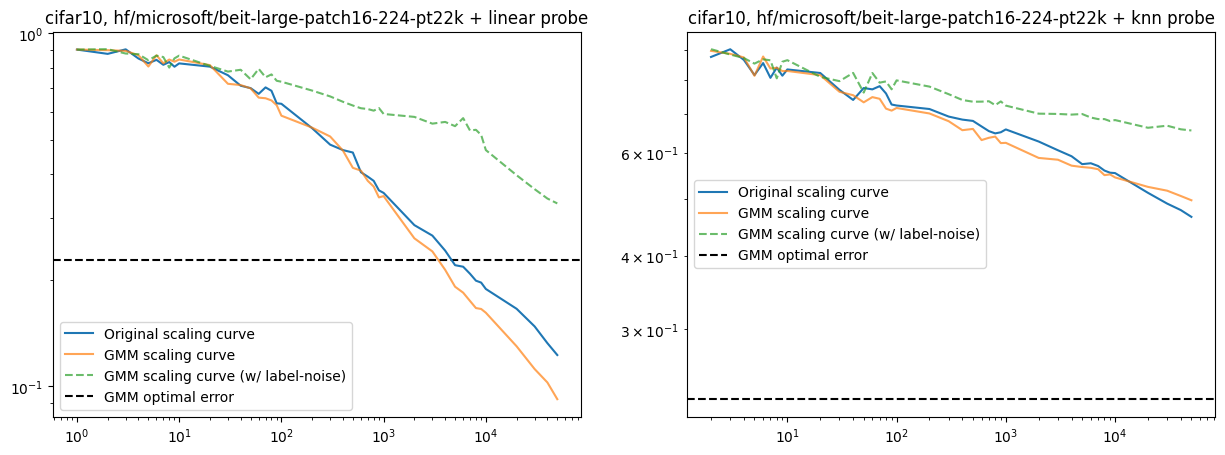

In [12]:
plt.figure(figsize=(15, 5))
for i, probe_type in enumerate(("linear", "knn")):
    plt.subplot(1, 2, i + 1)

    cdf = df.query(f"probe == '{probe_type}' & ~per_class").sort_values(
        "n_train"
    )
    plt.plot(cdf.n_train, cdf.err, label="Original scaling curve")

    cdf = df_gmm.query(f"probe == '{probe_type}' & ~per_class").sort_values(
        "n_train"
    )
    plt.plot(cdf.n_train, cdf.err, label="GMM scaling curve", alpha=0.7)

    cdf = df_gmm_noised.query(
        f"probe == '{probe_type}' & ~per_class"
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train,
        cdf.err,
        label="GMM scaling curve (w/ label-noise)",
        alpha=0.7,
        linestyle="--",
    )
    plt.axhline(
        ds_gmm_noised.metadata["errs"].mean(),
        label="GMM optimal error (w/ label-noise)",
        linestyle="--",
        color="black",
        zorder=-1,
    )

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.title(
        f"{probe_cfg.dataset_cfg.id}, {probe_cfg.embedder_cfg.id} + {probe_type} probe"
    )